# 手语识别

## 导入所取得库以及依赖

In [38]:
import cv2
from cv2 import cvtColor, COLOR_RGB2BGR, COLOR_BGR2RGB
import numpy as np
import os
from matplotlib import pyplot as plt
import time
# from mediapipe.solutions.holistic import FACE_CONNECTIONS
import mediapipe as mp

## 创建姿态识别并且进行标记的方法

In [39]:
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

In [40]:
def mediapipe_detection(image, model):
    """
    由于opencv采集的图像是使用的BGR模式采集，所以首先转换为RGB模式。
    之后，处理图像。返回图像与处理结果。
    :param image: 需要检测的图像
    :param model: mp_holistic 模型
    :return: 图片，结果
    """
    image = cvtColor(image, COLOR_BGR2RGB)  # 将色彩空间转换为rgb，opencv采集的数据是bgr
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cvtColor(image, COLOR_RGB2BGR)  # COLOR COVERSION RGB 2 BGR
    return image, results

In [41]:
def draw_landmarks(image, results):
    """
    该函数用于绘制身体姿态
    :param image:
    :param results:
    :return:None.
    """
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)  # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)  # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)  # Draw right hand connections

In [42]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
                              )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
                              )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
                              )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                              )

In [114]:
## 进行录像
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # print(results.)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [116]:
type(results)

type

In [117]:
results.right_hand_landmarks.landmark  #

AttributeError: 'NoneType' object has no attribute 'landmark'

如果最后一帧画面没有采集到右手，那么`right_hand_landmarks`的类型会是$Nonetype$

In [118]:
draw_landmarks(frame, results)

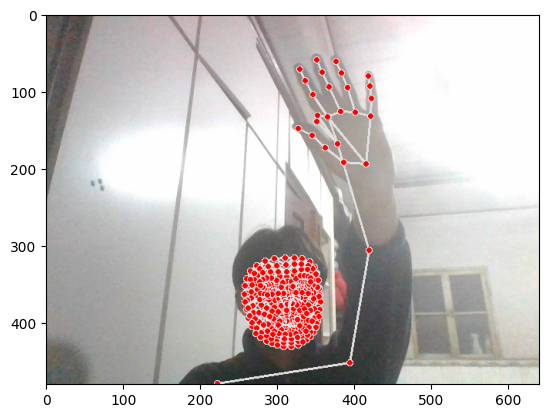

In [119]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [120]:
len(results.left_hand_landmarks.landmark)

21

In [121]:
len(results.pose_landmarks.landmark)

33

In [122]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])  # 将x,y,z，visibility这四个参数放到一个数组之中
    pose.append(test)

In [103]:
len(results.pose_landmarks.landmark)

33

**身体，面部，左手，右手的姿态转换为`np.array`存储到列表之中**
+ 左手右手：21*3
+ 面部：468*3
+ 身体:33*4      除了$(x,y,z)$,还有`visibility`属性

In [123]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in
                 results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in
                 results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in
               results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
rh = np.array([[res.x, res.y, res.z] for res in
               results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)

In [124]:
lh.shape  # 由于在最后一帧里没有采集到右手数据，将右手的坐标数据都设置为0

(63,)

In [125]:
face = np.array([[res.x, res.y, res.z] for res in
                 results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [126]:
face

array([ 0.49475566,  0.80907708, -0.02627429, ...,  0.53658146,
        0.72368824,  0.02483366])

In [55]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in
                     results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33 * 4)
    face = np.array([[res.x, res.y, res.z] for res in
                     results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468 * 3)
    lh = np.array([[res.x, res.y, res.z] for res in
                   results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[res.x, res.y, res.z] for res in
                   results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(
        21 * 3)
    return np.concatenate([pose, face, lh, rh])

In [128]:
result_test = extract_keypoints(results)

In [130]:
len(result_test)

1662

In [58]:
np.save('0', result_test)  # 将数据以npm的形式进行保存

In [67]:
len(np.load('0.npy'))

1662

**创建文件夹**

In [132]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [133]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## 采集数据集

In [134]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                #                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # NEW Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
# cap.release()
# cv2.destroyAllWindows()

In [104]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [106]:
label_map = {label: num for num, label in enumerate(actions)}

In [107]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [108]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

FileNotFoundError: [Errno 2] No such file or directory: 'MP_Data\\hello\\6\\19.npy'

In [109]:
np.array(sequences).shape

(6, 30, 1662)

In [110]:
X = np.array(sequences)

In [111]:
X.shape

(6, 30, 1662)

In [112]:
y = to_categorical(labels).astype(int)

In [ ]:
## 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

## 训练数据，创建$LSTM$神经网络

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
res = [.7, 0.2, 0.1]

In [ ]:
actions[np.argmax(res)]

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [ ]:
model.summary()

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[4])]

In [ ]:
actions[np.argmax(y_test[4])]

In [ ]:
model.save('action.h5')

In [ ]:
model.load_weights('action.h5')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

In [ ]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]


def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                    cv2.LINE_AA)

    return output_frame

In [ ]:
plt.figure(figsize=(18, 18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
sequence.reverse()

In [ ]:
len(sequence)

In [ ]:
sequence.append('def')

In [ ]:
sequence.reverse()

In [ ]:
sequence[-30:]

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        #         sequence.insert(0,keypoints)
        #         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            #3. Viz logic
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
(num_sequences, 30, 1662)

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))